# Thermal Design Project

## Problem Statement
A heat exchanger manufacturing firm has hired your team to design a shell and tube heat exchanger. The heat
exchanger is expected to heat 10,000 kg/h of water flowing through the tubes from 16 to 84°C. The hot
engine oil flowing through the shell is used for heating the water. The oil makes a single shell pass, entering
at 160°C and leaving at 94°C, with an average overall heat transfer coefficient Uh = 400 W/m²-K. The water
flows through 11 brass tubes (k = 137 W/m.K) of 22.9-mm inside diameter and 25.4-mm outside
diameter, with each tube making four passes through the shell, as shown below

Declare known variables, make necessary imports, and interpolate for property values.

In [19]:
import math as m
import matplotlib.pyplot as plt
import pandas as pd
from pyXSteam.XSteam import XSteam

# Setup steam table for accessing property values
steam_table = XSteam(XSteam.UNIT_SYSTEM_BARE) # m/kg/sec/K/MPa/W

# Cold Water in tubes, properties at 323K
mc      = 10000 / 3600 # kg / s
Tci     = 16 # deg C
Tco     = 84 # deg C
v       = steam_table.vL_t(323) # m^3/kg
rho     = 1 / v # kg/m^3
Cpc     = 1000*steam_table.CpL_t(323) # J/(kg*K)
mew     = steam_table.my_pt(0.1, 323) # N*s/m^2
kwater  = steam_table.tcL_t(323) # W/(m*K)
Pr      = Cpc * mew / kwater # unitless

Unfortunately, no Python library with engine oil data currently exists, so values will have to come from a textbook. The following function was made using scipy.optimize.curve_fit and a fourth order polynomial with the data from Appendix A: Table A.5 from *Fundamentals of Heat and Mass Transfer* by Bergman, Lavine, Incropera, and Dewitt.

In [20]:
def oil_specific_heat(x):
    a,b,c,d,e = 7.57640461e-07, -1.16948468e-03,  6.76308996e-01, -1.69259798e+02, 1.72835141e+04
    return (a*x**4+b*x**3+c*x**2+d*x+e)

# Hot engine oil in shell, properties at 400K
Thi     = 160 # deg C
Tho     = 94 # deg C
ho      = 400 # W/(m^2*K)
Cph     = oil_specific_heat(400) # J/(kg*K)

Lastly, the Shell and Tube state can be set.

In [21]:
# Shell and tube size
N       = 11 # number of brass tubes
kbrass  = 137 # W/(m*K), assume doesn't change
Di      = 0.0229 # m
Do      = 0.0254 # m
Npass   = 4 # number of passes per tube

## Part A<br />
Write a computer program to determine the required tube length per pass, assuming fully developed flow conditions for the water. Use correction factor F = 0.86 when using LMTD method. The tube is considered relatively new with a fouling factor of R"=0.002 K*m^2/W for the water side.

In [22]:
# Given correction factor and fouling factor
F       = 0.86              # unitless
Rfoul   = 0.002            # K*m^2/W

# Begin by finding h for the water flowing inside the tube, 
Re      = (4*mc) / (N*m.pi*Di*mew) # unitless, turbulent, Eq 8.6, pg. 520
NUd     = 0.023 * Re**0.8 * Pr**0.4     # unitless, heating, Eq 8.60, pg. 544
hi      = NUd * kwater / Di             # W/(m^2*K), Eq 7.52, pg. 458

# Multiply both sides by Ao, then take the inverse to get U
# Assumed Fouling factor for outer edge was 0. Page 709, Table 11.1 for possible value
U       = ((Do / (Di*hi)) + (Do*Rfoul / Di) + (Do*m.log(Do/Di) / (2*kbrass)) + (1 / ho))**(-1)  # W/(m^2*K), Eq 11.5, pg 710

# Solution method using LMTD
q_LMTD  = mc*Cpc*(Tco - Tci) # W, Eq 11.7b, pg. 711
dT1     = Thi - Tco # deg C, Eq 11.17, pg. 715
dT2     = Tho - Tci # deg C, Eq 11.17, pg. 715
dTlm    = (dT1 - dT2) / (m.log(dT1/dT2)) # deg C, Eq 11.15, pg. 714

# Solve for L in the equation q = U*As*dTlm
As      = q_LMTD / (F * U * dTlm) # m^2, Eq 11.14, pg. 714
l_LMTD  = As / (m.pi*Do*N*Npass) # m
print(f'LMTD: The required tube length per pass is {l_LMTD:.2f} meters.')

# Solution method using NTU
# Cc uses total mass flow rate. See Example 11.5 pg 732-733
Cc      = mc * Cpc # W/K, Section 11.3.3 first paragraph, pg. 715
q_NTU   = Cc*(Tco - Tci) # W, Eq 11.7b, pg. 711
Ch      = q_NTU / (Thi - Tho) # W/K, Eq 11.6b, pg. 711

# Determine which C value is lower and assign Cmin and max
if Ch < Cc:
    Cmin = Ch # W/K
    Cmax = Cc # W/K
else:           
    Cmin = Cc # W/K
    Cmax = Ch # W/K
Cr      = Cmin / Cmax # unitless, Section 11.4.2 (paragraph before Table 11.3), pg. 724

# Find max heat transfer and then sue the ratio to find efficiency
qmax    = Cmin * (Thi - Tci)    # W, Eq 11.18, pg. 722
e       = q_NTU / qmax          # unitless, Eq 11.19, pg. 722

# From Table 11.4 - Shell and tube, one shell pass
E       = ((2/e) - (1+Cr)) / (1+Cr**2)**(0.5)          # unitless, Table 11.4, Eq 11.30c, pg. 725
NTU     = -(1+Cr**2)**(-0.5) * m.log((E-1)/(E+1))      # unitless, Table 11.4, Eq 11.30b, pg. 725
A       = NTU * Cmin / U                               # m^2, Eq 11.24, pg. 723
l_NTU   = A / (m.pi * Do * N * Npass)                  # m
print(f'NTU: The required tube length per pass is {l_NTU:.2f} meters.')

LMTD: The required tube length per pass is 17.10 meters.
NTU: The required tube length per pass is 17.15 meters.


## Part B<br />
For the tube length found in part A, calculate the water-side
        convection coefficient, water outlet temperature, oil outlet 
        temperature, and effectiveness as a function of the water flow rate
        for 5000 < m < 15,000 kg/hr, (use 1000 Kg/hr increment) with all 
        other conditions remaining the same. Present all the calculated 
        results in a table for 3 mass flow rates (8000, 10000, 12000, 15000).

In [23]:
# Change these values to change the range of evaluated mass flow rates
# Changing mincr changes the increment value
mlow    = 5000     # kg / h
mhigh   = 15000    # kg / h
mincr   = 1000     # kg / h
mc_lst  = [x for x in range(mlow, mhigh+1, mincr)]

# Calculate mh and Areas using NTU results from Part A
mh      = Ch / Cph                       # kg/s, Eq 11.6b, pg. 711
Ao      = m.pi*Do*l_NTU*N*Npass          # m^2
Ai      = m.pi*Di*l_NTU*N*Npass          # m^2

# Create dataframe to store values
rowName = ['Tco (°C)', 'Tho (°C)','Cc (W/K)','Ch (W/K)','Red (Water)', '\u0394P (kPa)','NUd (Water)','hc (W/(m^2\u22C5K))','R (K/W)\u22C510^5','Uh (W/(m^2\u22C5K))','NTU','\u03B5','q (kW)']
df      = pd.DataFrame(index=rowName)

# Iterate through the mass flow rates. Initially assume Tave is the same as Part A. Check the result at the end and recalculate if needed
aveTcGuess   = (Tco + Tci) / 2 + 273    # K
aveThGuess   = (Tho + Thi) / 2 + 273    # K
for mc in mc_lst:
    while True:

        # Find properties at the average temperature
        v       = steam_table.vL_t(aveTcGuess) # m^3/kg
        rho     = 1 / v # kg/m^3
        Cpc     = 1000*steam_table.CpL_t(aveTcGuess) # J/(kg*K)
        mew     = steam_table.my_pt(0.1, aveTcGuess) # N*s/m^2
        kwater  = steam_table.tcL_t(aveTcGuess) # W/(m*K)
        Pr      = Cpc * mew / kwater # unitless
        Cph     = oil_specific_heat(aveThGuess) # J/(kg*K)

        # Find hc. All values we are required to test are turbulent
        Red     = (4*mc) / (3600*N*m.pi*Di*mew) # unitless, turbulent, Eq 8.6, pg. 520
        NUd     = (0.023) * (Red**0.8) * (Pr**0.4) # unitless, heating, Eq 8.60, pg. 544
        hi      = NUd * kwater / Di # W/(m^2*K), Eq 7.52, pg. 458

        # Find U and R
        U  = ((Do / (Di*hi)) + (Do*Rfoul / Di) + (Do*m.log(Do/Di) / (2*kbrass)) + (1 / ho))**(-1)  # W/(m^2*K), Eq 11.5, pg 710
        R  = 1 / (U * Ao)           # K/W
        
        # Find Cmin to use the NTU method
        Cc      = mc*Cpc / 3600 # W/K (Value is given in kg/h to stay consistent with problem statement)
        Ch      = mh*Cph # W/K
        if Ch < Cc:
            Cmin    = Ch # W/K
            Cmax    = Cc # W/K
        else:           
            Cmin    = Cc # W/K
            Cmax    = Ch # W/K
        Cr      = Cmin / Cmax # unitless

        # Find NTU and then efficiency
        NTU     = U*A / Cmin # unitless, Eq 11.24, pg. 723
        e       = 2*(1 + Cr + (1+Cr**2)**(0.5) * ((1 + m.exp(-NTU*(1+Cr**2)**(0.5)))/(1 - m.exp(-NTU*(1+Cr**2)**(0.5)))))**(-1) # unitless, Table 11.3, Eq 11.30a, pg. 724

        # Find q and then Tco and Tho
        qmax    = Cmin * (Thi - Tci) # W, Eq 11.18, pg. 722
        q       = e * qmax # W, Eq 11.19, pg.722
        Tco     = Tci + (q/Cc) # deg C, Eq 11.7b, pg. 711
        Tho     = Thi - (q/Ch) # deg C, Eq 11.6b, pg. 711

        # Calculate pressure drop
        f       = (0.790 * m.log(Red) - 1.64)**(-2) # unitless, turbulent, smooth surface, Eq 8.21, Pg 522
        uMean   = mc / (3600 * rho * m.pi * (Di/2)**2) # m/s Eq 8.5, pg. 519
        delP    = f*Npass*l_NTU * ((rho*uMean**2)/(2*Di)) # Pa, Eq 8.22a, pg. 523
        
        # Recalculate the average hot and cold temperature
        aveTc   = (Tci+Tco) / 2 + 273   # K
        aveTh   = (Thi+Tho) / 2 + 273   # K

        # Check to see if the properties were evaluated at a temperature within .1 deg of real average
        if abs(aveTcGuess-aveTc) <= .1:
            if abs(aveThGuess-aveTh) <= .1:
                # If so, add row to dataframe and break the while loop
                df[f'{mc} kg/h'] = [Tco, Tho, Cc, Ch, Red, delP*10**(-3), NUd, hi, R*10**5, U, NTU, e, q*10**(-3)]
                break
        else:
            # If not, then set the guessed average temperature value to the previous result
            aveTcGuess  = aveTc # K
            aveThGuess  = aveTh # K

# Round the values in table to 2 decimal places, remove columns that do not match mass flow rates requested by problem
df      = df.round(2)
df1     = df[['8000 kg/h', '10000 kg/h', '12000 kg/h', '15000 kg/h']]
print(' Part B: Results with Fouling Factor = 0.002 K*m^2/W')
df1



 Part B: Results with Fouling Factor = 0.002 K*m^2/W


,8000 kg/h,10000 kg/h,12000 kg/h,15000 kg/h
Tco (°C),94.54,84.00,75.81,66.56
Tho (°C),99.30,94.00,90.09,85.84
Cc (W/K),9291.42,11610.38,13930.23,17411.58
Ch (W/K),12022.92,11963.05,11918.92,11871.01
Red (Water),22347.29,25625.98,28658.96,32949.61
ΔP (kPa),1124.65,1693.93,2368.76,3571.40
NUd (Water),111.18,128.84,145.35,168.63
hc (W/(m^2⋅K)),3136.31,3602.63,4034.42,4639.26
R (K/W)⋅10^5,8.44,8.36,8.31,8.25
Uh (W/(m^2⋅K)),196.79,198.58,199.89,201.33


## Part C

Plot the results of part B. Scale each variable so that all are presented on the same graph.

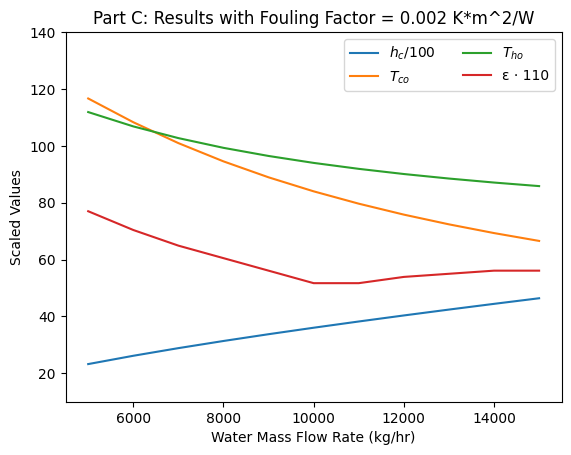

In [24]:
# Transpose dataframe because it is easier to access columns
df = df.transpose()

# Plotting code
plt.figure()

# Scale the convection coefficient by 80 to keep it on graph
plt.plot(mc_lst, [x/100 for x in df['hc (W/(m^2⋅K))']], label='$h_{c}/100$')

# Plot the cold output temperature
plt.plot(mc_lst, df['Tco (°C)'], label='$T_{co}$')

# Plot the hot output temperature
plt.plot(mc_lst, df['Tho (°C)'], label='$T_{ho}$')

# Scale the efficienty by 120 to keep it near the rest of the graph
plt.plot(mc_lst, [x*110 for x in df['\u03B5']], label='\u03B5 \u22C5 110')

# Set labels and titles
plt.ylabel('Scaled Values')
plt.xlabel('Water Mass Flow Rate (kg/hr)')
plt.title('Part C: Results with Fouling Factor = 0.002 K*m^2/W')

# Force graph to go to 140 and then split legend in two so it does not overlap Tho
plt.axis((4500, 15500, 10, 140))
plt.legend(loc='upper right', ncol=2)
plt.show()